## Box-counting algorithm implementation

Here I describe my implementation of the box-counting algorithm, which is used to estimate the fractal dimension of the Urban Form.

To write my code, I used elements from three sources:

- https://francescoturci.net/2016/03/31/box-counting-in-numpy/

- https://stackoverflow.com/questions/44793221/python-fractal-box-count-fractal-dimension

The above are python implementations of the box counting algorithm.

I also used elements and checked the description of this MATLAB code:

- https://www.mathworks.com/matlabcentral/fileexchange/13063-boxcount?focused=5083247&tab=example

(I have seen a paper ( https://ac.els-cdn.com/S1470160X16303168/1-s2.0-S1470160X16303168-main.pdf?_tid=8dab1834-b542-4ba7-b67b-3b705d6a310e&acdnat=1549146490_1fc7cf97fa0f3f57d4d1fe73fe78b24b ) using that code, so I suppose I can trust it.


Let's give a short description of the code/algorithm; more comments on the code itsel:

- The first step is to get an rgb image (such as a .png generated from the plot functions of OSMnx) and transform it to a grayscale, that is a 2-dimensional matrix with a numerical value between 0 and 1 in each point (pixel). Note the counter-intuitive fact of this transformation: regions that are darker in the original picture, get a value close to 0 and pixels that are white get a value close to 1.0.


- Denote the matrix resulting from this process as X. The main function $\texttt{fractal_dimension(X, threshold)}$ gets as an input this matrix and a threshold (between 0 and 1). [That will be used to binarize the matrix; as a default I use threshold = 0.5. That means that all pixels with value less than 0.5 (remember, values close to zero mean that there was a building/road etc in the original photo - in practice most pixels that represent a part of a building will have a value of 0, except some pixels in the boundaries that are a bit shaded... )].


- This function performs the following:

   1) Counts the number of 2-dimensional boxes (squares) needed to cover the pixels with a value below our threshold. The box sizes, $s$ are powers of 2. $s = 1, 2, 4, \dots, 2^P$ (the size refers to the number of pixels in each side of the 2 dimensional box).  $P$ is the smallest integer such that max(size(X)) <= $2^P$. 
   
  2) If the sizes of X over each dimension are smaller than $2^P$, X is padded with ones to size $2^P$ over each dimension ( for example a $320 \times 200$ image is padded to $512 \times 512$).
  
  3) To count the number of boxes of size $s$, I use the 2-d histogram function of scipy: First I find the positions in the (padded) matrix X that have a value less than the threshold. Then I get the 2 dimensional histogram of them with bins equal to size $s$. Last, I count the non-zero bins; this is the number of boxed we are looking for.
  
  4) Thus we get arrays of sizes $s$ and number of counts $N$, both of size $P + 1$.
  
  5) The box-counting fractal dimension is defined as:
  \begin{equation}
  D_{box} = \lim_{s \to 0} \frac{N(s)}{1/s}
  \end{equation}
  In practice, we plot $N(s)$ vs $s$, we perform a linear fit and get as our estimate of the fractal dimension the inverse of the slope.
  
 
More details in the code...




In [24]:
# Import some stuff first
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
from matplotlib import rcParams
from skimage.color import rgb2gray
import pylab as pl
rcParams['font.family'] = 'serif'
%matplotlib inline
%pylab inline

plot_pretty()

Populating the interactive namespace from numpy and matplotlib


In [25]:
def box_counts(x,y, n_bins, hist_range):
    """
    This function uses the 2-dimensional histogram to count the number of bins 
    that contain at least one non-zero element.
    ------------------------------------------
    Inputs:
    x, y: One dimensional-arrays. They contain the positions (i,j) where there is
    a pixel of the matrix X (see next function) that contains "something" (buiding, street etc)
    n_bins : Number of bins in each dimension. Since the input matrix is square, the number of bins
    is the same in both dimensions.
    hist_range: [[x_min, y_max], [y_min, y_max]]. The maximum and minimum limits of the bins. In practice
    this is always [0, len(X)].
    ------------------------------------------
    Returns:
    Number of boxes with non-zero counts
    """
    # Get a 2-d histogram of the points x,y
    Hist, xedg, yedg = np.histogram2d(x,y, bins=n_bins, range=hist_range, density=False)
    
    # Get the number of bins that contain at least one point
    counts = np.sum(Hist>0)
    
    return counts

In [26]:
def fractal_dimension(X, threshold):
    """
    Calculates the fractal dimension of an image in grayscale
    ---------------------------
    Inputs:
    X: 2-Dimensional matrix. Each value is a pixel with values 0-1. 
    threshold: When X[i,j] < threshold, assume that "something" is there (building, street etc)
    ---------------------------
    Returns:
    Frac_dim: the estimated fractal dimension
    size, counts: arrays of size p+1 that contain the boxes sizes and the number of counts 
    needed to cover the "fractal" per size. That is good if we want to plot and inspect
    """
    # Get the maximum dimension of the 2-d array X
    M_dim = max(X.shape)
    
    # Get p. p is the smallest integer such that max(size(X)) <= 2P.
    p = np.ceil((np.log(M_dim)/np.log(2.0)))
    
    # The integer version of it now
    int_p = int(p)
    
    print("Maximum power of 2 used:", int_p)
    # =========================================
    # Number of rows and  columns of the input matrix X
    rows = len(X[:,0])
    cols = len(X[0,:])
    
    # ========================================
    # Now create a padded square matrix, with size 2^p in each dimension
    len_X = int(2.0**int_p) # Its length in each dimension
    
    #Initialize it with ones everywhere
    X_padded = np.ones([len_X,len_X])
    
    # Now substitute in it the elements of the input matrix X.
    # Matrix X has smaller (or equal) dimensions than X_padded
    for i in range(rows):
        for j in range(cols):
            X_padded[i,j] = X[i,j]
            
    # =========================================
    # Now find the position of pixels of X_padded with value < threshold
    x_s = [] #Empty list for the i positions
    y_s = [] #Empty list for the j positions
    
    for i in range(len_X):
        for j in range(len_X):
            if (X_padded[i,j]<threshold):
                x_s.append(i)
                y_s.append(j)
                
    # Transform the lists to arrays
    x_arr = np.asarray(x_s)
    y_arr = np.asarray(y_s)
    
    # Just to see that everything looks ok, let's plot here
    # We can comment out this in later implementations, not necessary
    pl.plot(y_arr, x_arr, '.', ms=0.01)
    pl.show()
    
    # =========================================
    # Now an array of exponents, from p to 0
    exponents = np.arange(int_p, -1, -1)   # Note: here I can possibly change the minimum box size, instead of zero
    
    # Box sizes, 2^i, i = [p, ..., 0]. So in pizels 2^p, ....., 1
    sizes = 2.0**exponents 
    
    # =========================================
    # =========================================
    
    # Here perform the box counting using the 2-d histogram function
    
    # Limits of the histogram in all cases 
    hist_ranges = [[0,len_X], [0, len_X]]
    
    # Number of bins for each bin size s:
    # It is the reverse of the bin size array. In other words when the size is 2^p the number of bins is
    # just one, when the bin size is 1, we have 2^p bins etc
    n_bins = sizes[::-1]
    
    length = len(exponents) # the length of the arrays
    # Initialize an array of counts 
    counts = np.zeros(length)
    
    #Now populate the counts array - run a for loop in all box sizes
    for i in range(length):
        num_bin = int(n_bins[i]) #Number of bins - make it integer
        
        print("Runs for bin size:", sizes[i])
        
        counts[i] = box_counts(x_arr,y_arr, num_bin, hist_ranges)
    
    # Now perform a linear fit
    coeffs= np.polyfit(np.log10(sizes), np.log10(counts), 1)
    # Fractal dimension = - the slope
    Frac_dim = - coeffs[0]
    
    print ("The estimated  fractal dimension is:", Frac_dim)
    
    return Frac_dim, sizes, counts

### Let's apply the algorithm using as inputs pictures of the building footprints and drivable street network of Monrovia, Liberia

These were created using the plotting functions from OSMnx... Just as an example, we have to think and discuss the details....

#### Fractal Dimension of Monrovia buildings first....



In [27]:
# Read and convert to gray scale 
I = rgb2gray(pl.imread("Monrovia_buildings.png"))

('Maximum power of 2 used:', 13)


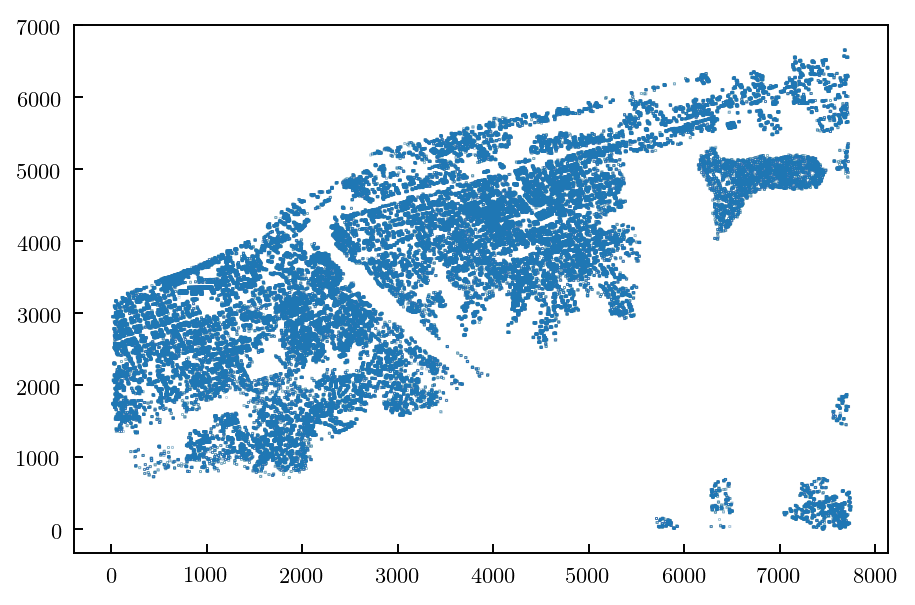

('Runs for bin size:', 8192.0)
('Runs for bin size:', 4096.0)
('Runs for bin size:', 2048.0)
('Runs for bin size:', 1024.0)
('Runs for bin size:', 512.0)
('Runs for bin size:', 256.0)
('Runs for bin size:', 128.0)
('Runs for bin size:', 64.0)
('Runs for bin size:', 32.0)
('Runs for bin size:', 16.0)
('Runs for bin size:', 8.0)
('Runs for bin size:', 4.0)
('Runs for bin size:', 2.0)
('Runs for bin size:', 1.0)
('The estimated  fractal dimension is:', 1.6299393619796185)


In [28]:
# Calculate the fractal dimension 
FD, siz, counts = fractal_dimension(I, 0.5)

Print log of sizes vs counts to see them

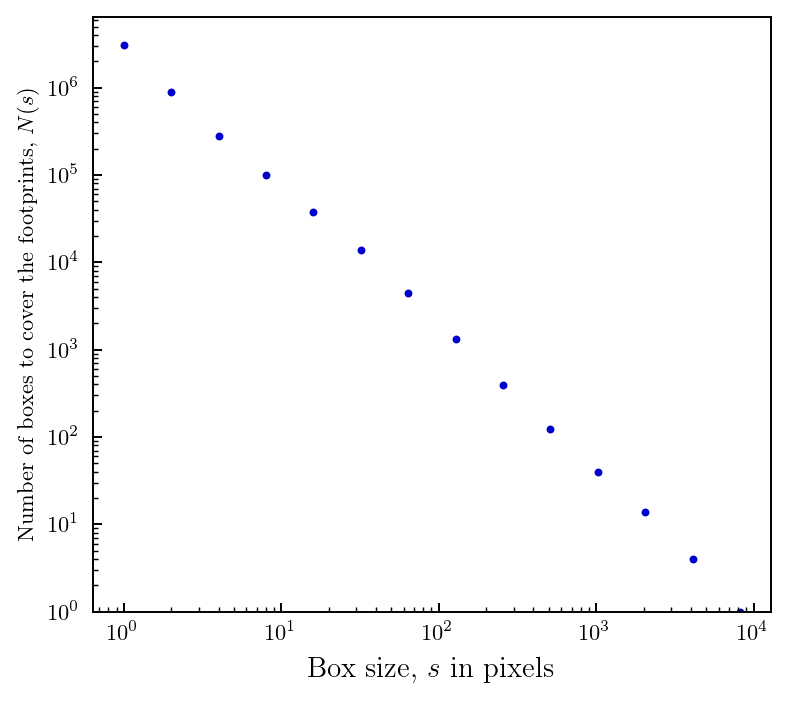

In [32]:
fig = plt.figure(figsize = (5.0,4.5))

plt.scatter(siz, counts, s= 5.0, color='mediumblue')
plt.xscale('log');plt.yscale('log')

plt.xlabel('Box size, $s$ in pixels', fontsize=12)
plt.ylabel('Number of boxes to cover the footprints, $N(s)$')

plt.ylim(1,)

plt.show()

#### Now of the Monrovia drivable streets

In [34]:
# Read and convert to gray scale 
J = rgb2gray(pl.imread("Monrovia_streets.png"))

('Maximum power of 2 used:', 13)


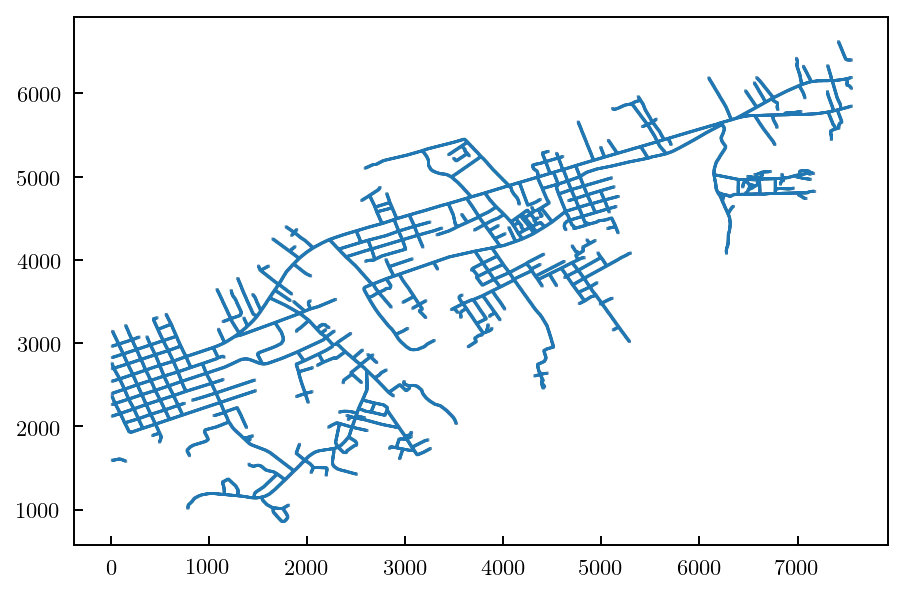

('Runs for bin size:', 8192.0)
('Runs for bin size:', 4096.0)
('Runs for bin size:', 2048.0)
('Runs for bin size:', 1024.0)
('Runs for bin size:', 512.0)
('Runs for bin size:', 256.0)
('Runs for bin size:', 128.0)
('Runs for bin size:', 64.0)
('Runs for bin size:', 32.0)
('Runs for bin size:', 16.0)
('Runs for bin size:', 8.0)
('Runs for bin size:', 4.0)
('Runs for bin size:', 2.0)
('Runs for bin size:', 1.0)
('The estimated  fractal dimension is:', 1.4587798668247791)


In [35]:
# Calculate the fractal dimension 
FD, siz, counts = fractal_dimension(J, 0.5)

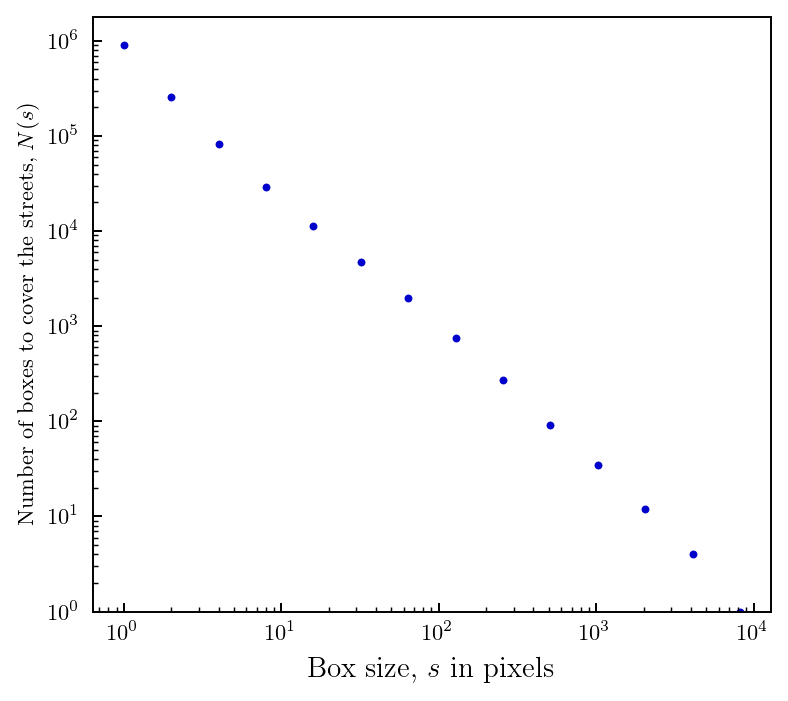

In [37]:
fig = plt.figure(figsize = (5.0,4.5))

plt.scatter(siz, counts, s= 5.0, color='mediumblue')
plt.xscale('log');plt.yscale('log')

plt.xlabel('Box size, $s$ in pixels', fontsize=12)
plt.ylabel('Number of boxes to cover the streets, $N(s)$')

plt.ylim(1,)

plt.show()

### So, FD of the footprints = 1.63
### And FD of the street network = 1.46